# MsPASS Getting Started Tutorial
## *Gary L. Pavlis and Yinzhi (Ian) Wang*
## Preliminaries
This tutorial assumes you have already done the following:
1.  Installed docker.
2.  Run the commmand `docker pull wangyinz/mspass_tutorial` 
3.  Launched docker using the tutorial container.
4.  Connected the container to get this tutorial running.

Our installation manual describes how to do that so we assume that was completed for you to get this far. 

Note MsPASS can also be run from a local copy of MsPASS installed through pip.   The only difference is in launching jupyter-notebook to get this tutorial running.   None of the tutorial should depend upon which approach you are using.  Further, if either approach was not done correctly you can expect python errors at the first import of a mspasspy module.  

## Download data with obspy
### Overview of this section
MsPASS leans heavily on obspy.  In particular, in this section we will use obspy's web services functions to download waveform data, station metadata, and source metadata.  The approach we are using here is to stage these data to your local disk.   The dataset we will assemble is the mainshock and X days of larger aftershocks of the Tohoku earthquake.  The next section then covers how we import these data into the MsPASS framework to allow them to be processed.

### Select, download, and save source data in MongoDB
As noted we are focusing on the Tohoku earthquake and its aftershocks.  That earthquake's origin time is approximately  March 11, 2011, at 5:46:24 UTC.  The ISC epicenter is 38.30N, 142.50E.  We will then apply obspy's *get_events* function with the following time and area filters:
1.  Starttime March 11, 2011, 1 hour before the origin time.
2.  End time 7 days after the mainshock origin time.
3.  Epicenters within + or - 3 degrees Latitude
4.  Epicenters within + or - 3 degrees of Longitude. 
5.  Only aftershocks larger than 6.5
Here is the incantation in obspy to do that:

In [21]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
client=Client("IRIS")
t0=UTCDateTime('2011-03-11T05:46:24.0')
starttime=t0-3600.0
endtime=t0+(7.0)*(24.0)*(3600.0)
lat0=38.3
lon0=142.5
minlat=lat0-3.0
maxlat=lat0+3.0
minlon=lon0-3.0
maxlon=lon0+3.0
minmag=6.5

cat=client.get_events(starttime=starttime,endtime=endtime,
        minlatitude=minlat,minlongitude=minlon,
        maxlatitude=maxlat,maxlongitude=maxlon,
        minmagnitude=minmag)
print(cat)

11 Event(s) in Catalog:
2011-03-12T01:47:16.160000Z | +37.590, +142.751 | 6.5 MW
2011-03-11T19:46:35.300000Z | +38.800, +142.200 | 6.5 mb
...
2011-03-11T05:51:20.500000Z | +37.310, +142.240 | 6.8 None
2011-03-11T05:46:23.200000Z | +38.296, +142.498 | 9.1 MW
To see all events call 'print(CatalogObject.__str__(print_all=True))'


We can save these easily into MongoDB for use in later processing with this simple command.

In [22]:
from mspasspy.db.database import Database
from mspasspy.db.client import DBClient
dbclient=DBClient()
db=Database(dbclient,'getting_started',db_schema='mspass_lite.yaml', md_schema='mspass_lite.yaml')
n=db.save_catalog(cat)
print('number of event entries saved in source collection=',n)

number of event entries saved in source collection= 11


### Select, download, and save station metadata to MongoDB
We use a very similar procedure to download and save station data.   We again use obspy but in this case we use their *get_stations* function to construct what they call an "Inventory" object containing the station data. 

In [23]:
inv=client.get_stations(network='TA',starttime=starttime,endtime=endtime,
                        format='xml',channel='BH?',level='response')
net=inv.networks
x=net[0]
sta=x.stations
print("Number of stations retrieved=",len(sta))
print(inv)

Number of stations retrieved= 446
Inventory created at 2021-05-24T14:44:03.000000Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.47
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2011-03-11...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			TA
		Stations (446):
			TA.034A (Hebronville, TX, USA)
			TA.035A (Encino, TX, USA)
			TA.035Z (Hargill, TX, USA)
			TA.109C (Camp Elliot, Miramar, CA, USA)
			TA.121A (Cookes Peak, Deming, NM, USA)
			TA.133A (Hamilton Ranch, Breckenridge, TX, USA)
			TA.134A (White-Moore Ranch, Lipan, TX, USA)
			TA.135A (Vickery Place, Crowley, TX, USA)
			TA.136A (Ennis, TX, USA)
			TA.137A (Heron Place, Grand Saline, TX, USA)
			TA.138A (Matatall Enterprise, Big Sandy, TX, USA)
			TA.139A (Bunkhouse Ranch, Marshall, TX, USA)
			TA.140A (Cam and Jess, Hughton, LA, USA)
			TA.141A (Papa Simpson, Farm, Arcadia, LA, USA)
			TA.142A (Monroe, LA, USA)
			TA.143A (Socs Landing, Pioneer, LA, USA)
			TA.214A (Organ 

The output shows we just downloaded the data form 446 TA stations that were running during this time period. Note a detail is if you want full response information stored in the database you need to specify *level='response'* as we have here.  The default is never right.  You need to specify level as at least "channel". 

We will now save these data to MongoDB with a very similar command to above: 

In [24]:
ret=db.save_inventory(inv,verbose=True)
print('save_inventory returned value=',ret)

net:sta:loc= TA : 034A :  for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 034A :  : BHE for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 034A :  : BHN for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 034A :  : BHZ for time span  2010-01-08T00:00:00.000000Z  to  2011-11-17T17:05:00.000000Z  added to channel collection
net:sta:loc= TA : 035A :  for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 035A :  : BHE for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T17:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 035A :  : BHN for time span  2010-01-12T00:00:00.000000Z  to  2011-11-14T17:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 035A :  : B

net:sta:loc:chan= TA : 233A :  : BHN for time span  2009-11-18T00:00:00.000000Z  to  2011-10-01T14:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 233A :  : BHZ for time span  2009-11-18T00:00:00.000000Z  to  2011-10-01T14:15:00.000000Z  added to channel collection
net:sta:loc= TA : 234A :  for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 234A :  : BHE for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 234A :  : BHN for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 234A :  : BHZ for time span  2009-11-17T00:00:00.000000Z  to  2011-10-01T16:45:00.000000Z  added to channel collection
net:sta:loc= TA : 236A :  for time span  2010-04-25T00:00:00.000000Z  to  2012-01-20T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 236A :  : B

net:sta:loc:chan= TA : 345A :  : BHN for time span  2011-03-17T00:00:00.000000Z  to  2012-01-18T22:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 345A :  : BHZ for time span  2011-03-17T00:00:00.000000Z  to  2012-01-18T22:45:00.000000Z  added to channel collection
net:sta:loc= TA : 346A :  for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 346A :  : BHE for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 346A :  : BHN for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 346A :  : BHZ for time span  2011-03-18T00:00:00.000000Z  to  2013-02-05T17:45:00.000000Z  added to channel collection
net:sta:loc= TA : 433A :  for time span  2009-11-10T00:00:00.000000Z  to  2011-10-02T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 433A :  : B

net:sta:loc:chan= TA : 535A :  : BHZ for time span  2010-07-05T19:15:00.000000Z  to  2011-10-06T13:55:00.000000Z  added to channel collection
net:sta:loc= TA : 536A :  for time span  2010-01-14T00:00:00.000000Z  to  2011-11-08T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 536A :  : BHE for time span  2010-01-14T00:00:00.000000Z  to  2011-11-08T17:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 536A :  : BHN for time span  2010-01-14T00:00:00.000000Z  to  2011-11-08T17:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 536A :  : BHZ for time span  2010-01-14T00:00:00.000000Z  to  2011-11-08T17:30:00.000000Z  added to channel collection
net:sta:loc= TA : 537A :  for time span  2010-01-31T00:00:00.000000Z  to  2011-11-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 537A :  : BHE for time span  2010-01-31T00:00:00.000000Z  to  2011-11-05T15:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 537A :  : B

net:sta:loc:chan= TA : 646A :  : BHZ for time span  2011-03-17T00:00:00.000000Z  to  2013-01-27T18:35:00.000000Z  added to channel collection
net:sta:loc= TA : 733A :  for time span  2009-12-03T00:00:00.000000Z  to  2011-10-11T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 733A :  : BHE for time span  2009-12-03T00:00:00.000000Z  to  2011-10-11T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 733A :  : BHN for time span  2009-12-03T00:00:00.000000Z  to  2011-10-11T18:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 733A :  : BHZ for time span  2009-12-03T00:00:00.000000Z  to  2011-10-11T18:40:00.000000Z  added to channel collection
net:sta:loc= TA : 734A :  for time span  2009-12-02T00:00:00.000000Z  to  2011-10-11T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : 734A :  : BHE for time span  2009-12-02T00:00:00.000000Z  to  2011-10-11T14:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : 734A :  : B

net:sta:loc:chan= TA : A30A :  : BHE for time span  2009-08-19T00:00:00.000000Z  to  2011-07-15T16:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : A30A :  : BHN for time span  2009-08-19T00:00:00.000000Z  to  2011-07-15T16:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : A30A :  : BHZ for time span  2009-08-19T00:00:00.000000Z  to  2011-07-15T16:20:00.000000Z  added to channel collection
net:sta:loc= TA : A31A :  for time span  2010-08-25T00:00:00.000000Z  to  2012-06-23T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : A31A :  : BHE for time span  2010-08-25T00:00:00.000000Z  to  2012-06-23T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : A31A :  : BHN for time span  2010-08-25T00:00:00.000000Z  to  2012-06-23T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : A31A :  : BHZ for time span  2010-08-25T00:00:00.000000Z  to  2012-06-23T16:45:00.000000Z  added to channel collection
net:sta:loc= TA : A3

net:sta:loc= TA : C25A :  for time span  2009-07-25T00:00:00.000000Z  to  2011-08-24T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : C25A :  : BHE for time span  2009-07-25T00:00:00.000000Z  to  2011-08-24T15:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : C25A :  : BHN for time span  2009-07-25T00:00:00.000000Z  to  2011-08-24T15:50:00.000000Z  added to channel collection
net:sta:loc:chan= TA : C25A :  : BHZ for time span  2009-07-25T00:00:00.000000Z  to  2011-08-24T15:50:00.000000Z  added to channel collection
net:sta:loc= TA : C26A :  for time span  2009-07-26T00:00:00.000000Z  to  2011-06-09T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : C26A :  : BHE for time span  2009-07-26T00:00:00.000000Z  to  2011-06-09T18:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : C26A :  : BHN for time span  2009-07-26T00:00:00.000000Z  to  2011-06-09T18:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : C26A :  : B

net:sta:loc:chan= TA : D29A :  : BHE for time span  2009-08-05T00:00:00.000000Z  to  2011-06-28T21:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D29A :  : BHN for time span  2009-08-05T00:00:00.000000Z  to  2011-06-28T21:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D29A :  : BHZ for time span  2009-08-05T00:00:00.000000Z  to  2011-06-28T21:35:00.000000Z  added to channel collection
net:sta:loc= TA : D30A :  for time span  2009-08-07T00:00:00.000000Z  to  2011-06-25T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : D30A :  : BHE for time span  2009-08-07T00:00:00.000000Z  to  2011-06-25T15:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D30A :  : BHN for time span  2009-08-07T00:00:00.000000Z  to  2011-06-25T15:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : D30A :  : BHZ for time span  2009-08-07T00:00:00.000000Z  to  2011-06-25T15:40:00.000000Z  added to channel collection
net:sta:loc= TA : D3

net:sta:loc:chan= TA : E34A :  : BHZ for time span  2010-08-26T00:00:00.000000Z  to  2012-07-31T16:20:02.000000Z  added to channel collection
net:sta:loc= TA : E35A :  for time span  2010-08-25T00:00:00.000000Z  to  2012-07-29T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : E35A :  : BHE for time span  2010-08-25T00:00:00.000000Z  to  2012-07-29T21:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E35A :  : BHN for time span  2010-08-25T00:00:00.000000Z  to  2012-07-29T21:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E35A :  : BHZ for time span  2010-08-25T00:00:00.000000Z  to  2012-07-29T21:40:00.000000Z  added to channel collection
net:sta:loc= TA : E36A :  for time span  2010-10-17T00:00:00.000000Z  to  2012-07-29T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : E36A :  : BHE for time span  2010-10-17T00:00:00.000000Z  to  2012-07-29T16:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : E36A :  : B

net:sta:loc= TA : F35A :  for time span  2010-09-10T00:00:00.000000Z  to  2012-07-27T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : F35A :  : BHE for time span  2010-09-10T00:00:00.000000Z  to  2012-07-27T18:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : F35A :  : BHN for time span  2010-09-10T00:00:00.000000Z  to  2012-07-27T18:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : F35A :  : BHZ for time span  2010-09-10T00:00:00.000000Z  to  2012-07-27T18:55:00.000000Z  added to channel collection
net:sta:loc= TA : F36A :  for time span  2010-09-11T00:00:00.000000Z  to  2012-07-27T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : F36A :  : BHE for time span  2010-09-11T00:00:00.000000Z  to  2012-07-27T22:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : F36A :  : BHN for time span  2010-09-11T00:00:00.000000Z  to  2012-07-27T22:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : F36A :  : B

net:sta:loc:chan= TA : H25A :  : BHN for time span  2009-06-19T00:00:00.000000Z  to  2011-08-23T16:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H25A :  : BHZ for time span  2009-06-19T00:00:00.000000Z  to  2011-08-23T16:15:00.000000Z  added to channel collection
net:sta:loc= TA : H26A :  for time span  2009-06-20T00:00:00.000000Z  to  2011-06-02T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : H26A :  : BHE for time span  2009-06-20T00:00:00.000000Z  to  2011-06-02T16:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H26A :  : BHN for time span  2009-06-20T00:00:00.000000Z  to  2011-06-02T16:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : H26A :  : BHZ for time span  2009-06-20T00:00:00.000000Z  to  2011-06-02T16:15:00.000000Z  added to channel collection
net:sta:loc= TA : H27A :  for time span  2009-06-10T00:00:00.000000Z  to  2011-05-27T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : H27A :  : B

net:sta:loc:chan= TA : I05D :  : BHN for time span  2009-10-20T00:00:00.000000Z  to  2016-09-30T19:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I05D :  : BHZ for time span  2009-10-20T00:00:00.000000Z  to  2016-09-30T19:30:00.000000Z  added to channel collection
net:sta:loc= TA : I25A :  for time span  2009-06-23T00:00:00.000000Z  to  2011-05-28T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : I25A :  : BHE for time span  2009-06-23T00:00:00.000000Z  to  2011-05-28T16:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I25A :  : BHN for time span  2009-06-23T00:00:00.000000Z  to  2011-05-28T16:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : I25A :  : BHZ for time span  2009-06-23T00:00:00.000000Z  to  2011-05-28T16:25:00.000000Z  added to channel collection
net:sta:loc= TA : I26A :  for time span  2009-06-18T00:00:00.000000Z  to  2011-05-08T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : I26A :  : B

net:sta:loc:chan= TA : J25A :  : BHZ for time span  2009-06-06T00:00:00.000000Z  to  2011-05-10T18:05:00.000000Z  added to channel collection
net:sta:loc= TA : J26A :  for time span  2009-07-31T00:00:00.000000Z  to  2011-06-01T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : J26A :  : BHE for time span  2009-07-31T00:00:00.000000Z  to  2011-06-01T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : J26A :  : BHN for time span  2009-07-31T00:00:00.000000Z  to  2011-06-01T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : J26A :  : BHZ for time span  2009-07-31T00:00:00.000000Z  to  2011-06-01T16:55:00.000000Z  added to channel collection
net:sta:loc= TA : J27A :  for time span  2009-08-01T00:00:00.000000Z  to  2011-05-11T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : J27A :  : BHE for time span  2009-08-01T00:00:00.000000Z  to  2011-05-11T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : J27A :  : B

net:sta:loc:chan= TA : K33A :  : BHN for time span  2010-07-20T00:00:00.000000Z  to  2012-05-12T15:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K33A :  : BHZ for time span  2010-07-20T00:00:00.000000Z  to  2012-05-12T15:35:00.000000Z  added to channel collection
net:sta:loc= TA : K34A :  for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : K34A :  : BHE for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K34A :  : BHN for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : K34A :  : BHZ for time span  2010-07-28T00:00:00.000000Z  to  2012-04-26T15:15:00.000000Z  added to channel collection
net:sta:loc= TA : K35A :  for time span  2010-07-28T00:00:00.000000Z  to  2012-05-16T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : K35A :  : B

net:sta:loc:chan= TA : M04C :  : BHZ for time span  2009-10-11T00:00:00.000000Z  to  2014-04-15T19:55:00.000000Z  added to channel collection
net:sta:loc= TA : M28A :  for time span  2009-05-14T00:00:00.000000Z  to  2011-04-11T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : M28A :  : BHE for time span  2009-05-14T00:00:00.000000Z  to  2011-04-11T16:10:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M28A :  : BHN for time span  2009-05-14T00:00:00.000000Z  to  2011-04-11T16:10:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M28A :  : BHZ for time span  2009-05-14T00:00:00.000000Z  to  2011-04-11T16:10:00.000000Z  added to channel collection
net:sta:loc= TA : M29A :  for time span  2009-05-12T00:00:00.000000Z  to  2011-04-07T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : M29A :  : BHE for time span  2009-05-12T00:00:00.000000Z  to  2011-04-07T19:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : M29A :  : B

net:sta:loc:chan= TA : N34A :  : BHZ for time span  2010-05-14T00:00:00.000000Z  to  2012-04-22T14:35:00.000000Z  added to channel collection
net:sta:loc= TA : N35A :  for time span  2010-05-15T00:00:00.000000Z  to  2012-04-21T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : N35A :  : BHE for time span  2010-05-15T00:00:00.000000Z  to  2012-04-21T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N35A :  : BHN for time span  2010-05-15T00:00:00.000000Z  to  2012-04-21T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N35A :  : BHZ for time span  2010-05-15T00:00:00.000000Z  to  2012-04-21T15:45:00.000000Z  added to channel collection
net:sta:loc= TA : N36A :  for time span  2010-11-19T00:00:00.000000Z  to  2012-08-31T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : N36A :  : BHE for time span  2010-11-19T00:00:00.000000Z  to  2012-08-31T21:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : N36A :  : B

net:sta:loc:chan= TA : O33A :  : BHN for time span  2010-05-19T00:00:00.000000Z  to  2012-04-18T21:35:00.000000Z  added to channel collection
net:sta:loc:chan= TA : O33A :  : BHZ for time span  2010-05-19T00:00:00.000000Z  to  2012-04-18T21:35:00.000000Z  added to channel collection
net:sta:loc= TA : O34A :  for time span  2010-06-11T00:00:00.000000Z  to  2012-04-18T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : O34A :  : BHE for time span  2010-06-11T00:00:00.000000Z  to  2012-04-18T15:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : O34A :  : BHN for time span  2010-06-11T00:00:00.000000Z  to  2012-04-18T15:20:00.000000Z  added to channel collection
net:sta:loc:chan= TA : O34A :  : BHZ for time span  2010-06-11T00:00:00.000000Z  to  2012-04-18T15:20:00.000000Z  added to channel collection
net:sta:loc= TA : O35A :  for time span  2010-05-16T00:00:00.000000Z  to  2012-04-21T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : O35A :  : B

net:sta:loc:chan= TA : P36A :  : BHE for time span  2010-05-28T00:00:00.000000Z  to  2012-03-14T14:54:28.000000Z  added to channel collection
net:sta:loc:chan= TA : P36A :  : BHN for time span  2010-05-28T00:00:00.000000Z  to  2012-03-14T14:54:28.000000Z  added to channel collection
net:sta:loc:chan= TA : P36A :  : BHZ for time span  2010-05-28T00:00:00.000000Z  to  2012-03-14T14:54:28.000000Z  added to channel collection
net:sta:loc= TA : P37A :  for time span  2010-11-27T00:00:00.000000Z  to  2012-09-25T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : P37A :  : BHE for time span  2010-11-27T00:00:00.000000Z  to  2012-09-25T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P37A :  : BHN for time span  2010-11-27T00:00:00.000000Z  to  2012-09-25T15:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : P37A :  : BHZ for time span  2010-11-27T00:00:00.000000Z  to  2012-09-25T15:45:00.000000Z  added to channel collection
net:sta:loc= TA : P3

net:sta:loc:chan= TA : Q39A :  : BHZ for time span  2010-12-01T00:00:00.000000Z  to  2012-09-28T16:00:00.000000Z  added to channel collection
net:sta:loc= TA : Q40A :  for time span  2010-12-06T00:00:00.000000Z  to  2012-09-13T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Q40A :  : BHE for time span  2010-12-06T00:00:00.000000Z  to  2012-09-13T00:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Q40A :  : BHN for time span  2010-12-06T00:00:00.000000Z  to  2012-09-13T00:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Q40A :  : BHZ for time span  2010-12-06T00:00:00.000000Z  to  2012-09-13T00:15:00.000000Z  added to channel collection
net:sta:loc= TA : R11A :  for time span  2007-02-09T00:00:00.000000Z  to  2017-03-16T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : R11A :  : BHE for time span  2008-07-02T03:15:00.000000Z  to  2017-03-16T19:15:00.000000Z  added to channel collection
net:sta:loc:chan= TA : R11A :  : B

net:sta:loc= TA : S32A :  for time span  2009-10-11T00:00:00.000000Z  to  2011-08-26T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : S32A :  : BHE for time span  2009-10-11T00:00:00.000000Z  to  2011-08-26T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S32A :  : BHN for time span  2009-10-11T00:00:00.000000Z  to  2011-08-26T16:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S32A :  : BHZ for time span  2009-10-11T00:00:00.000000Z  to  2011-08-26T16:45:00.000000Z  added to channel collection
net:sta:loc= TA : S33A :  for time span  2009-10-16T00:00:00.000000Z  to  2011-08-26T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : S33A :  : BHE for time span  2009-10-16T00:00:00.000000Z  to  2011-08-26T13:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S33A :  : BHN for time span  2009-10-16T00:00:00.000000Z  to  2011-08-26T13:45:00.000000Z  added to channel collection
net:sta:loc:chan= TA : S33A :  : B

net:sta:loc:chan= TA : T33A :  : BHN for time span  2009-10-15T00:00:00.000000Z  to  2011-08-27T14:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : T33A :  : BHZ for time span  2009-10-15T00:00:00.000000Z  to  2011-08-27T14:05:00.000000Z  added to channel collection
net:sta:loc= TA : T34A :  for time span  2010-05-05T00:00:00.000000Z  to  2012-03-06T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : T34A :  : BHE for time span  2010-05-05T00:00:00.000000Z  to  2012-03-06T22:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : T34A :  : BHN for time span  2010-05-05T00:00:00.000000Z  to  2012-03-06T22:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : T34A :  : BHZ for time span  2010-05-05T00:00:00.000000Z  to  2012-03-06T22:40:00.000000Z  added to channel collection
net:sta:loc= TA : T35A :  for time span  2010-05-06T00:00:00.000000Z  to  2012-03-06T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : T35A :  : B

net:sta:loc= TA : U36A :  for time span  2010-06-19T00:00:00.000000Z  to  2012-02-12T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : U36A :  : BHE for time span  2010-06-19T00:00:00.000000Z  to  2012-02-12T20:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U36A :  : BHN for time span  2010-06-19T00:00:00.000000Z  to  2012-02-12T20:30:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U36A :  : BHZ for time span  2010-06-19T00:00:00.000000Z  to  2012-02-12T20:30:00.000000Z  added to channel collection
net:sta:loc= TA : U37A :  for time span  2010-06-17T00:00:00.000000Z  to  2012-02-19T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : U37A :  : BHE for time span  2010-06-17T00:00:00.000000Z  to  2012-02-19T16:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U37A :  : BHN for time span  2010-06-17T00:00:00.000000Z  to  2012-02-19T16:05:00.000000Z  added to channel collection
net:sta:loc:chan= TA : U37A :  : B

net:sta:loc= TA : W36A :  for time span  2010-04-13T00:00:00.000000Z  to  2012-02-01T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : W36A :  : BHE for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : W36A :  : BHN for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : W36A :  : BHZ for time span  2010-04-13T00:00:00.000000Z  to  2011-09-09T15:59:59.000000Z  added to channel collection
net:sta:loc= TA : W37B :  for time span  2011-01-28T00:00:00.000000Z  to  2012-02-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : W37B :  : BHE for time span  2011-01-28T00:00:00.000000Z  to  2012-02-05T15:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : W37B :  : BHN for time span  2011-01-28T00:00:00.000000Z  to  2012-02-05T15:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : W37B :  : B

net:sta:loc:chan= TA : Y33A :  : BHN for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T16:55:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y33A :  : BHZ for time span  2009-11-08T00:00:00.000000Z  to  2011-09-07T16:55:00.000000Z  added to channel collection
net:sta:loc= TA : Y34A :  for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Y34A :  : BHE for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T16:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y34A :  : BHN for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T16:40:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Y34A :  : BHZ for time span  2009-11-07T00:00:00.000000Z  to  2011-09-05T16:40:00.000000Z  added to channel collection
net:sta:loc= TA : Y35A :  for time span  2010-04-26T00:00:00.000000Z  to  2012-01-31T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Y35A :  : B

net:sta:loc:chan= TA : Z40A :  : BHN for time span  2011-02-05T00:00:00.000000Z  to  2012-11-10T17:25:00.000000Z  added to channel collection
net:sta:loc:chan= TA : Z40A :  : BHZ for time span  2011-02-05T00:00:00.000000Z  to  2012-11-10T17:25:00.000000Z  added to channel collection
net:sta:loc= TA : Z41A :  for time span  2011-03-10T00:00:00.000000Z  to  2016-08-10T23:59:59.000000Z  added to site collection
net:sta:loc:chan= TA : Z41A :  : BHE for time span  2011-03-10T00:00:00.000000Z  to  2012-06-22T17:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : Z41A :  : BHN for time span  2011-03-10T00:00:00.000000Z  to  2012-06-22T17:59:59.000000Z  added to channel collection
net:sta:loc:chan= TA : Z41A :  : BHZ for time span  2011-03-10T00:00:00.000000Z  to  2012-06-22T17:59:59.000000Z  added to channel collection
Database.save_inventory processing summary:
Number of site records processed= 446
number of site records saved= 446
number of channel records processed= 1338
numb

We turned on verbose mode so the output is quite large, but we did that because it demonstrates what this Database method is doing.  It takes apart the complicated Inventory object obspy created from the stationxml data we downloaded and turns the result into a set of documents saved in the two main station metadata collections in MongoDB:  (1) *site* for station information and (2) *channel* that contains most of the same data as *site* but add a set of important additional information (notably component orientation and response data).  

We turn now to the task of downloading the waveform data.

### Download waveform data
The last download step for this tutorial is the one that will take the most time and consume the most disk space;  downloading the waveform data.   To keep this under control we keep only a waveform section spanning most of the body waves.   We won't burden you with the details of how we obtained the following rough numbers we use to define the waveform downloading parameters:

1.  The approximate distance from the mainshock epicenter to the center of the USArray in 2011 is 86.5 degrees.
2.  P arrival is expected about 763 s after the origin time
3.  S arrival is expected about 1400 s after the origin time

Since we have stations spanning the continent we will use the origin time of each event +P travel time (763 s) - 4 minutes as the start time.  For the end time we will use the origin time + S travel time (1400 s) + 10 minutes.  

This process will be driven by origin times from the events we downloaded earlier.   We could drive this by using the obspy *Catalog* object created above, but because saved the event data to the database we will use this opportunity to illustrate how that data is managed in MsPASS.

First, let's go over the data we saved in MongoDB.  We saved these data in a *collection* we call *source*.   For those familiar with relational databases a MongoDB "collection" plays a role similar to a table (relation) in a relational database.   A "collection" contains one or more "documents".  A "document" in MongoDB is analagous to a single tuple in a relational database.  The internal structure of a MongoDB is, however, very different being represented by binary storage of name-value pairs in a format they call BSON because the structure can be represented in human readable form as a common format today called JSON.   A key point for MsPASS to understand is the BSON (JSON) documents stored in MongoDB map directly into a python dict container.   We illustrate that in the next box by printing the event hypocenter data we downloaded above and then stored in MongoDB:

In [25]:
dbsource=db.source
cursor=dbsource.find()   # This says to retrieve and iterator overall all source documents
# The Cursor object MongoDB's find function returns is iterable
print('Event in tutorial dataset')
evlist=list()
for doc in cursor:
    lat=doc['lat']
    lon=doc['lon']
    depth=doc['depth']
    origin_time=doc['time']
    mag=doc['magnitude']
    # In MsPASS all times are stored as epoch times. obspy's UTCDateTime function easily converts these to 
    # a readable form in the print statment here but do that only for printing or where required to 
    # interact with obspy
    print(lat,lon,depth,UTCDateTime(origin_time),mag)
    evlist.append([lat,lon,depth,origin_time,mag])

Event in tutorial dataset
37.5898 142.7512 24.8 2011-03-12T01:47:16.160000Z 6.5
38.8 142.2 33.0 2011-03-11T19:46:35.300000Z 6.5
39.2219 142.5316 18.9 2011-03-11T11:36:40.030000Z 6.5
36.1862 141.6639 26.0 2011-03-11T08:19:27.470000Z 6.5
38.051 144.6297 19.8 2011-03-11T06:25:50.740000Z 7.6
36.0675 141.7291 23.0 2011-03-11T06:20:02.390000Z 6.5
36.0692 142.1388 23.0 2011-03-11T06:18:51.060000Z 6.6
36.2274 141.088 25.4 2011-03-11T06:15:37.570000Z 7.9
38.9847 143.4632 20.0 2011-03-11T06:08:32.540000Z 6.7
37.31 142.24 33.0 2011-03-11T05:51:20.500000Z 6.8
38.2963 142.498 19.7 2011-03-11T05:46:23.200000Z 9.1


Notice that we use python dict syntax to extract attributes like latitude ('lat' key) from "document" which acts like a python dict.  

We saved the core metadata attributes in a python list, *evlist*, to allow us to reduce the volume of data we will retrieve.  We'll keep just the three biggest events;  the mainshock and the two 7+ aftershocks.  We do that in the block below using a set container to define keepers.  The approach is a bit obscure and not the most efficient.  We could just use the list we just built to drive the processing in the next box, but we use the approach there to illustrate another example of how to loop over documents retrieved from MongoDB - a common thing you will need to do to work with MongoDB in MsPASS.

With that the loop below is similar to the simple print loop above, BUT requires an obscure parameter not usually discussed in the MongoDB documentation.   The problem we have to deal with is that the obspy web service downloader we are going to call in the loop below will take a while to complete (likely over an hour).  Long running processes interacting with MongoDB and using a "Cursor" object (the thing *find* returned) can fail and throw confusing messages from a timeout problem.  That is, a job will mysteriously fail with a message that does not always make the fundamental problem clear.  The solution is to create what some books call an "immortal cursor".   You will see this in the next box that does the waveform downloading as this line:
```
cursor=dbsource.find({},no_cursor_timeout=True)
```
where here we use an explicit "find all" with the (weird) syntax of "{}" and make the cursor immortal by setting no_cursor_timeout to True.

With that background here is the script to download data.  You might want to go grab a cup of coffee while this runs as it will take a while.  

In [26]:
from mspasspy.util.converter import Trace2TimeSeries

#db=Database(dbclient,'getting_started')
# We have to redefine the client from obspy to use their so called bulk downloader
from obspy.clients.fdsn import RoutingClient
client = RoutingClient("iris-federator")
# This uses the (admitted obscure) approach of a set container of keepers to reduce the download time
keepers=set()
keepers.add(4)
keepers.add(7)
keepers.add(10)

cursor=db.source.find({},no_cursor_timeout = True)
count=0
start_offset=763.0-4*60.0
end_offset=1400.0+10*60.0
i=0
for doc in cursor:
    if i in keepers: 
        origin_time=doc['time']
        # We need the ObjectId of the source to provide a cross reference to link our 
        # waveform data to the right source.  Better to do this now than later as association 
        # can be a big challenge
        id=doc['_id']
        
        print('Starting on event number',i,' with origin time=',UTCDateTime(origin_time))
        stime=origin_time+start_offset
        etime=origin_time+end_offset
        strm=client.get_waveforms(
            starttime=UTCDateTime(stime),
            endtime=UTCDateTime(etime),
            network='TA',
            channel='BH?',
            location='*'
        )
        # The output of get_waveforms is an obspy Stream object. Stream objects are iterable 
        # so we work through the group, converting each to a MsPASS TimeSeries, and then saving 
        # the results to the database.  
        for d in strm:
            d_mspass=Trace2TimeSeries(d)
            # Here is where we save the id linked to the source collection. 
            # We use a MsPASS convention that such metadata have name collection_id
            d_mspass['source_id'] = id
            #print('Saving data for sta=',d_mspass['sta'],' and chan=',d_mspass['chan'])
            db.save_data(d_mspass)   
            count += 1
    else:
        print('Skipping event number ',i,' with origin time=',UTCDateTime(origin_time))
    i += 1
print('Number of waveforms saved=',count)
    

Skipping event number  0  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  1  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  2  with origin time= 2011-03-11T05:46:23.200000Z
Skipping event number  3  with origin time= 2011-03-11T05:46:23.200000Z
Starting on event number 4  with origin time= 2011-03-11T06:25:50.740000Z
Skipping event number  5  with origin time= 2011-03-11T06:25:50.740000Z
Skipping event number  6  with origin time= 2011-03-11T06:25:50.740000Z
Starting on event number 7  with origin time= 2011-03-11T06:15:37.570000Z
Skipping event number  8  with origin time= 2011-03-11T06:15:37.570000Z
Skipping event number  9  with origin time= 2011-03-11T06:15:37.570000Z
Starting on event number 10  with origin time= 2011-03-11T05:46:23.200000Z
Number of waveforms saved= 3933


## Quick Look for QC
MsPASS has some basic graphics capabilities to display its standard data types.  We refer the reader to a the *BasicGraphics* tutorial for more details, but for now we just illustrate using the plotting for a quick look as a basic QC to verify we have what we were looking for.

The previous step used *save_data* to save the data we downloaded to MongoDB.   How it is stored is a topic for later, but here we'll retrieve some of that data and plot it to illustrate the value of abstracting the read and write operations.   Reading is slightly more complicated than writing one atomic object as we did above.  The reason is that we often want to do a database select operation to limit what we get.  This example illustrates some basics on MongoDB queries.  The reader is referred to extensive external documentation on MongoDB (books and many online sources) on this topic. 

Let's first grab the data for one station from all three events we saved.   This is a good illustration of the basic query mechanism used by MongoDB.  

In [28]:
from mspasspy.ccore.seismic import TimeSeriesEnsemble
sta='234A'
ensemble=TimeSeriesEnsemble()
ensemble['sta']=sta
query={ 'sta' : sta }
n=db.wf_TimeSeries.count_documents(query)
print('Trying to retrieve ',n,' TimeSeries objects for station=',sta)
curs=db.wf_TimeSeries.find(query)
for doc in curs:
    # With the current mspass_lite schema these extra options are required
    d=db.read_data(doc)
    ensemble.member.append(d)
print('Success:  number of members in this ensemble=',len(ensemble.member))    

Trying to retrieve  9  TimeSeries objects for station= 234A
Success:  number of members in this ensemble= 9


Notice that like *save_data* the default usage of *read_data* is about as simple as it gets;  you just point the reader at the document abstraction (the *doc* symbol) that defines a particular waveform and it is retrieved.  

A second point this example is a key concept in MsPASS.   We define two data objects as *Atomic* that we refer to as *TimeSeries* and *Seismogram*.   We are working with *TimeSeries* objects here because they were born from single channel records downloaded with FDSN web services.   Later in this tutorial we will convert the data now defined by the wf_TimeSeries collection to *Seismogram* objects and write them into a wf_Seismogram collection.  We call *Timeseries* and *Seismogram* object "Atomic" because for most processing they should be considered a single thing.  (For more experienced programs, note that in reality like atoms these data objects are made of subatomic particles with a class inheritance structure but the energy barrier to pull them apart is significant.)  Many functions, however, need the concept we call an *Ensemble*.   These are a collection of atomic objects that have a generic relationship.   Examples are "shot gathers", "CMP gathers", and "common receiver gathers" concepts used in seismic reflection processing.  An *Ensemble* is a container that can be any of those.  Your workflow needs to be aware at all times what is in any ensemble and be sure the requirements of an algorithm are met.  (e.g. in reflection processing you will junk if you think an ensemble is a NMO corrected CMP gather and the data are actually a raw shot gather).  

There are two named types of ensemble containers; one for each atomic data object.  They are called *TimeSeriesEnsemble* and *SeismogramEnsemble* for containers of *TimeSeries* and *Seismogram* object respectively.   In both cases the seismic data components are stored in simple list-like container defined with the symbol *member*. The container also can act a bit like a python dict to store global metadata related to the ensemble. We will refer to that container here as the *ensemble metadata*.   Our example above can be thought of as a common receiver gather for TA station 234A.  Hence, we post that name with the key *sta* with the line `ensemble['sta']=sta`.    That model should be the norm for any ensemble.   That is, the ensemble metadata should normally contain a set of one or more key-value pairs that at least provide a  hint at the ensemble contents.  Here that is the station name, but we could add other data like the stations coordinates.  We defer that to below where that data becomes necessary.  

With that background let's plot these data.  Here we illustrate the use of basic plotting routines in MsPASS but we note any python graphic package can be use for plotting these data if you understand the data structures.  We provide the *SeismicPlotter* class here as a convenience.  A valuable addition for community development is extensions of our basic graphics module or alternative plotting modules.

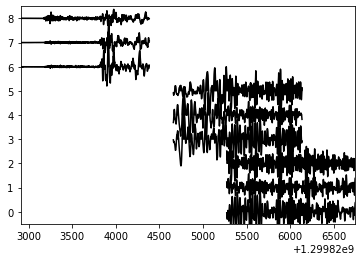

In [29]:
from mspasspy.graphics import SeismicPlotter
plotter=SeismicPlotter(normalize=True)
# TODO  default wtvaimg has a bug and produces a 0 height plot - wtva works for now
plotter.change_style('wtva')
plotter.plot(ensemble)

Again, about as simple as it gets.  This and the earlier examples illustrate a key design goal we had for MsPASS:  make the package as simple to use for beginners as possible.   The only trick we used here was to turn on automatic scaling (`normalize=True` line in the constructor) that is turned off by default.  Scaling is essential here since we are mixing data from events with different magnitudes.  

The plots shows the mainshock record as the top 3 signals.   Below that are sets of 3 signals from the other 2 large events in our data subset defined as "keepers".  Notice how the 3 sets of signals are offset in time.  The data are plotted that way because our the data time stamp is coordinated universal time (UTC) and they are being plotted in their actual timing position.   The topic of a UTC time standard and how MsPASS handles this is a unique feature of MsPASS and is the topic of next section.

The SeismicPlotter has a fair amount of additional functionality.  See the BasicGraphics tutorial to learn some of that functionality.

## UTC and Relative Time
A unique feature of MsPASS is that we aimed to make it generic by supporting multiple time standards.  MsPASS currently supports two time standards we refer to with the name keys *UTC* and *Relative*.   The first, *UTC*, is well understood by all seismologists who work with any modern data.  UTC is a standard abbreviation for coordinated univeral time, which is the time standard used on all modern data loggers.  It is important to recognize that unlike obspy we store all UTC times internally as "unix epoch times".  Epoch times are the number of seconds in UTC since the first instant of the year 1970.  We use only epoch times internally as it vastly simplifies storage of time attributes since they can be stored as a standard python float (always a 64 bit real number in python) that causes no complications in storage to MongoDB.  It also vastly simpifies computing time differences, which is a very common thing in data processing.   To convert UTC times to a human readable form we suggest using the obspy UTCDateTime class as we did above.  The inverse (converting a UTC date string to an epoch time) is simple with the timestamp method of UTCDateTime.  Some wrapped obspy functions require UTCDateTime objects but all database times are stored as floats. Most obspy function, like the web service functions we used above, use the UTCDateTime class to define.  The point is be to be cautious about what time arguments mean to different functions.

The idea of a *Relative* time is well known to anyone who has done seismic reflection processing.   Experienced SAC users will also understand the concept through a different mechanism that we generalize.  Time 0 for seismic reflection data ALWAYS means the time that the "shot" was fired.  That is a type example of what we mean by *Relative* time.   Earthquake data can be converted to the same concept by setting time zero for each signal to the origin time of the event.   SAC users will recognize that idea as the case of the "O" definition of the data's time stamp.   Our *Relative* time, in fact, is a generalization of SAC's finite set of definitions for the time stamp for one of their data files like Tn, B, O, etc.   *Relative* just means the data are relative to some arbitrary time stamp that we refer to internally as *t0_shift*.  It is the user's responsibility to keep track of what *t0_shift* means for your data and whether that reference is rational for the algorithm being run.  TimeSeries and Seismogram objects keep track of *t0_shift* and the reference can be shifted to a different time if desired through combinations of three different methods:  *rtoa* (switch from Relative to Absolute=UTC), *ator* (switch from Absolute(UTC) to Relative), and *shift* that is used to apply an relative time shift.   

In this next block we take the ensemble we created above and apply a time shift to put 0 at the predicted P wave arrival time.  

In [30]:
# We make a deep copy with this mechanism so we can restore raw data later
enscpy=TimeSeriesEnsemble(ensemble)
i=0
for d in ensemble.member:
    print('member ',i,' input t0 time=',UTCDateTime(d.t0))
    d.ator(d.t0)
    print('member ',i,' how has time 0=',d.t0)
    i+=1

member  0  input t0 time= 2011-03-11T06:34:33.000000Z
member  0  how has time 0= 0.0
member  1  input t0 time= 2011-03-11T06:34:33.024998Z
member  1  how has time 0= 0.0
member  2  input t0 time= 2011-03-11T06:34:33.024998Z
member  2  how has time 0= 0.0
member  3  input t0 time= 2011-03-11T06:24:20.000000Z
member  3  how has time 0= 0.0
member  4  input t0 time= 2011-03-11T06:24:20.024998Z
member  4  how has time 0= 0.0
member  5  input t0 time= 2011-03-11T06:24:20.000000Z
member  5  how has time 0= 0.0
member  6  input t0 time= 2011-03-11T05:55:06.000000Z
member  6  how has time 0= 0.0
member  7  input t0 time= 2011-03-11T05:55:06.000000Z
member  7  how has time 0= 0.0
member  8  input t0 time= 2011-03-11T05:55:06.000000Z
member  8  how has time 0= 0.0


Notice how the times changed from an offset from the origin time we used for downloading to 0.   We can see this effect graphically in the next box.  

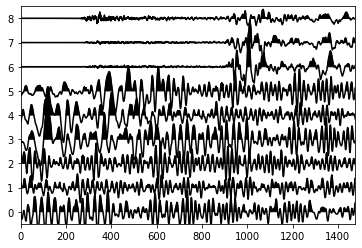

In [31]:
plotter.plot(ensemble)

Note that now the time axis starts at 0, BUT that is Relative time.  Here that time is a fixed offset from the origin time we obtained form the hypocenter origin time for each event.  

Those signals are ugly because these aftershocks are buried in the long period coda of the mainshock.  That should be clear from the UTC time plot we first made where the bottom six signals overlap, a common problem that presents a huge problem in some processing frameworks.   Let's plot this again with a bandpass filter applied.

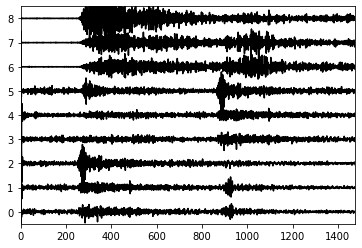

In [32]:
from mspasspy.algorithms.signals import filter
filter(ensemble,'bandpass',freqmin=0.2,freqmax=2.0)
plotter.plot(ensemble)

Notice that we can now see the P and S waves even for the two aftershocks in this extended short period band.  

## Windowing Data

The time scale we have in the plot above is largely useless;  it is just an arbitrary offset from the origin time for each event.   In this section we will illustrate the common processing step in dealing with teleseismic data where we need to extract a smaller time window around a phase of interest.  

First, as we just saw the aftershocks are a special problem because they are buried in low frequency coda of the mainshock.  We will thus focus for the rest of this tutorial on the mainshock.   First, let's load the vertical components of the mainshock into a working ensemble.   To do that, we first have to define a query method to extract only the data we want.   This will be a step you will nearly alway need to address in handling teleseismic data.  The previous examples and the steps below are a start, but we reiterate that if you become a serious user of MsPASS you will need to become familiar with the pymongo API.   Our documentation indirectly covers many of the essentials, but MongoDB is a large, heavily-used package with a lot of features.  

With that lecture, the key data we will  use is the start times printed in the box above that ran the ator method.  Here is the algorithm.  See comments below the run box that provide the lessons to be learned form this example:

Using this query
{'starttime': {'$gt': 1299822901.0, '$lt': 1299822911.0}, 'chan': 'BHZ'}
Mainshock ensemble size from time query= 437
Mainshock ensemble size using id query= 437


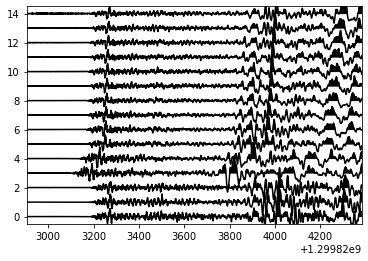

In [34]:
t_to_query=UTCDateTime('2011-03-11T05:55:06.000000')
# This is a MongoDB range query.   We allow a +- 5 s slop because the start 
# times are alway slightly irregular. 
# we also do an exact match test for BHZ.  That works for these data but 
# more elaborate queries with wildcards are subject best left to MongoDB documentation
dt_for_test=5.0
tmin=t_to_query-dt_for_test
tmax=t_to_query+dt_for_test
query={'starttime' : {'$gt': tmin.timestamp,'$lt' : tmax.timestamp }}
# query is a python dict so we can add to an additional criteria like this
query['chan']='BHZ'
print('Using this query')
print(query)
n=db.wf_TimeSeries.count_documents(query)
print('Mainshock ensemble size from time query=',n)
# We could just use that but let's get the special key source_id we set above
# and query with it as a more unambigous query
doc=db.wf_TimeSeries.find_one(query)
srcid=doc['source_id']
idquery={'source_id' : srcid}
idquery['chan']='BHZ'  # add same equality test of BHZ 
n=db.wf_TimeSeries.count_documents(idquery)
print('Mainshock ensemble size using id query=',n)
# Now build our working enemble.  To keep graphics clean we limit the 
# number retrieved to the first 15 stations.  Illustrates another pymongo function
ensemble=TimeSeriesEnsemble(15)
# Set the source_id into the ensembled metadata - this will now be a common source(shot)
# gather so appropriate to post it like this.  Might normally also add other source 
# metadata there but they aren't needed for this tutorial
ensemble['source_id']=doc['source_id']
cursor=db.wf_TimeSeries.find(idquery).limit(15)
for doc in cursor:
    d=db.read_data(doc)
    ensemble.member.append(d)
plotter.plot(ensemble)

Some things you should learn from this example working from the top down:
1.  With pymongo a query is constructed as a python dict.   Equality matches are implied by  constructs like `query['chan']='BHZ'`.  The starttime construct is more elaborate but note the key to the dict is *starttime* and the value associated with the key is itself a dict.  Note that the concept of what MongoDB calls a "document" maps exactly into a python dict container.  MongoDB would call the dict container that is the value associated with *starttime* a "subdocument".  The construct used for the *starttime* query uses MongoDB operators as the keys in the subdocument.  The operators are keywords that begin with the dollar sign ($) symbol.   There is a long list of operators that can be found in various MongoDB online sources [like this one.](https://docs.mongodb.com/manual/reference/operator/query/>)
2.  We constructed our query in two steps.  That isn't required.  We did it just to illustrate that a query can often best be constructed from a core set that can be defined with an incantation using curly brackets, colons, constants, and python variables.   It is sometimes useful to add constructs like the line for *chan* inside conditionals to handle different situation.  That programming trick is not discussed in most tutorials.
3.  We create a new TimeSeriesEnsemble with a different form of the constructor.  That constructor initializes the container setting aside 15 slots for TimeSeries.  It provides a minor improvement in efficiency.  All core data objects in MsPASS are implemented in C++ to improve performance.  Note that any symbol loaded with the path defined by *mspasspy.ccore* means the thing being accessed was written in C++ with python wrappers.  We do not currently have a clean mechanism for creating complete sphynx documentation pages for the C++ code.  Most of the API can be inferred from the C++ doxygen web page found [here.](https://wangyinz.github.io/mspass/cxx_api/mspass.html#mspass-namespace)
4.  Our example intentionally issues a second (redundant) query for the data of interest.  We do that strictly for the educational value this provides.  In this case they are exactly equivalent.  The two queries illustrate two ways to alternative mechanism (with these data) to assemble a common source gather (Ensemble).  The second query uses a special entity used extensively in MongoDB called a [ObjectID](https://docs.mongodb.com/manual/reference/method/ObjectId/).  The second query using a *source_id* value works only because we loaded that cross-refernce key with the data.  If you inspect the earlier boxes you will see we downloaded the data looping over a list of sources.  We defined *source_id* by extracting the ObjectID of the document holding the source information in the *source collection* referenced by the key `"_id"` of the linking source document.  (i.e. *source_id* is the same as the value associated with a document in the source collection with the key *_id*.) 
In MsPASS the standard model for data is that source and receiver information are stored in what MongoDB calls the [normalized data model](https://docs.mongodb.com/manual/core/data-model-design/).  The *read_data* method called in the loop loading the ensemble as the last step in this box will, by default, automatically load source information when it sees the magic key *source_id*.   The same mechanism is used for receiver data, but in its current state that cannot yet be done because we haven't yet built the required cross referencing.  The next step handles that inline, but for efficiency any workflow that requires receiver metadata would need a mechanism to associate each wf_TimeSeries document to a document in the *channel* collection.  

The last thing the above box does is plot the data. We see the data are again in UTC time and the data are not aligned because there is no "moveout correction".  The next step is then to convert the data to relative time and align the data on the predicted P wave arrival time.  The first step is to associate each TimeSeries object with the receiver metadata of the instrument that that recorded the data.  Because these data came from an FDSN data center (IRIS) a given channel of data is uniquely defined by the four magic SEED code names referred to as network, station, channel, and location.  In the standard MsPASS schema these are shortened to *net*, *sta*, *chan*, and *loc* respectively.  Here we use a preprocessing function called *get_seed_channel* to retrieve the basic station metadata and load that data into each member of the working ensemble.  

In [35]:
# Next step is to load source and station coordinates
from mspasspy.preprocessing.seed.ensembles import load_source_data_by_id
for d in ensemble.member:
    load_source_data_by_id(db,d)
    #print(d)
    net=d['net']
    sta=d['sta']
    chan=d['chan']
    # loc is sometimes undefined
    if d.is_defined('loc'):
        loc=d['loc']
    else:
        loc=None
    doc=db.get_seed_channel(net,sta,chan,loc,time=d.t0)
    d['channel_lat']=doc['lat']
    d['channel_lon']=doc['lon']
    d['channel_elev']=doc['elev']
    d['channel_hang']=doc['hang']
    d['channel_vang']=doc['vang']
    d['channel_id']=doc['_id']


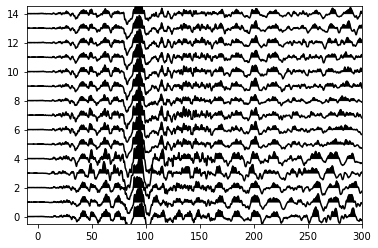

In [36]:
from mspasspy.algorithms.window import WindowData
from mspasspy.algorithms.signals import filter
from mspasspy.ccore.seismic import TimeWindow
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")
from obspy.geodetics import gps2dist_azimuth,kilometers2degrees

# This a time window in time relative to P arrival around 
# which we cut each waveform
cutwin=TimeWindow(-10.0,300.0)
i=0
for d in ensemble.member:
    filter(d,'bandpass',freqmax=2.0,freqmin=0.005)
    stalat=d['channel_lat']
    stalon=d['channel_lon']
    srclat=d['source_lat']
    srclon=d['source_lon']
    depth=d['source_depth']
    otime=d['source_time']
    georesult=gps2dist_azimuth(srclat,srclon,stalat,stalon)
    # obspy's function we just called returns distance in m in element 0 of a tuple
    # their travel time calculator it is degrees so we need this conversion
    dist=kilometers2degrees(georesult[0]/1000.0)
    arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist,phase_list=['P'])
    # Arrivals are returned in time order 0 is always the first arrival
    # This computes arrival time as an epoch time and shifts the data to put 0 at that time
    d.ator(otime+arrivals[0].time)
    #d=WindowData(d,cutwin)
    ensemble.member[i]=WindowData(d,cutwin)
    i+=1  
plotter.plot(ensemble)

The data are not aligned with 0 set as the predicted arrival time.  For seismologists this plot mostly illustrates the complex source-time function of this earthquake.  One way to clarify this is to calculate the full set of arrivals for this event.   An easy way to do that is to just recycle the last coordinates used.  We turn off the restriction to only calculate the P arrival time and print the default phase list returned by the tau-p calculator.  That will show you that the first major secondary phase, PP, does not arrive until around relative time 225 s.  Hence, the common signal between 0 and 225 is mainly a reflection of the source, not structure.  

In [37]:
arrivals=model.get_travel_times(source_depth_in_km=depth,distance_in_degree=dist)
print(arrivals)

31 arrivals
	P phase arrival at 792.528 seconds
	PcP phase arrival at 792.977 seconds
	pP phase arrival at 799.122 seconds
	sP phase arrival at 801.631 seconds
	PP phase arrival at 1015.619 seconds
	PKiKP phase arrival at 1079.348 seconds
	pPKiKP phase arrival at 1086.113 seconds
	sPKiKP phase arrival at 1088.586 seconds
	SKiKP phase arrival at 1292.792 seconds
	SKS phase arrival at 1425.078 seconds
	pSKS phase arrival at 1434.108 seconds
	sSKS phase arrival at 1436.637 seconds
	SKKS phase arrival at 1443.079 seconds
	S phase arrival at 1458.248 seconds
	ScS phase arrival at 1459.725 seconds
	pS phase arrival at 1466.922 seconds
	sS phase arrival at 1469.555 seconds
	SP phase arrival at 1531.039 seconds
	PS phase arrival at 1533.791 seconds
	PKIKKIKP phase arrival at 1818.321 seconds
	PKKP phase arrival at 1820.081 seconds
	SS phase arrival at 1834.662 seconds
	SKIKKIKP phase arrival at 2031.691 seconds
	PKIKKIKS phase arrival at 2034.163 seconds
	SKKP phase arrival at 2038.329 seconds

## Creating Seismogram Objects
MsPASS considers two data types to be atomic seismic data.  What we call a *TimeSeries* is a single channel of data.  As we saw above a unique seed combination of the codes net, sta, chan, and loc define a single channel data stream.  In all seismic data processing we usually cut out sections of data as a chunk to be dealt with as a single entity.  There are some algorithms where the model of a single channel of data is meaningless or useless.  Data recorded by a three-component seismic station is a case in point;  the components have a fundamental relationship that for some applications make them indivisible.  Two examples most seismologists will be familiar with are particle motion measurements and conventional receiver functions.   Both require an input of three-component data to make any sense.   For this reason we distinguish a differerent atomic object we call a *Seismogram* to define data that is by definition a three-component set of recordings.

The problem of assembling three-component data from raw data is not at all trivial. Today most data loggers produce multiple sample rate representations of the same data stream and observatory data like GSN stations frequently have multiple, three-component (3C) sensors at the same approximate location.  It is not at all uncommon to have 24 or more channels defining the same data with different sensors and different sample rates.  Active source multichannel data, by which I mean older cable systems were the data were multiplexed, present a different problem assembling three-component data as a map between channel number and component is required to put the components in the right place for each receiver position.  The primary reason we define a separate data object for 3C versus scalar data is too allow algorithms that depend upon 3C data to not be burdened with that complexity.  If the workflow you need for your research requires 3C data you should alway think of your workflow as four distinct steps:
1. Importing raw data as TimeSeries.  For MsPASS that always means selecting and cutting out time windows that define what part of what signals you need to work with.  The example above cutting data down to a P wave window is an example, but the concept is generic.
2. Populating the metadata that define at least two fundamental properties of all data channels to be handled:  (1) at least relative amplitudes between components and (2) orientations of the components in space.  Our example below will illustrate an example of how this needs to be done.
3. A generic process we call *bundle*.  Bundling is descriptive because the process requires the three components that define a particular sensor to be joined together an put into the single container we call a *Seismogram*.  
4.  Save the bundled data in some form.  In MsPASS the preferred form is storage under the control of MongoDB and MsPASS, but such data could also be exported in some output format for handling by some external package.  


In this tutorial we already completed step 1 and part of step 2.  What is missing from step 2 is that the wf_Seismogram records are currently incomplete.  To see that we will use the *find_one* method of MongoDB to get a quick peek at the first record (document) in our data set of TimeSeries objects: 

In [38]:
from bson import json_util
doc=db.wf_TimeSeries.find_one()
print(json_util.dumps(doc,indent=2))

{
  "_id": {
    "$oid": "60abbe5108b7fd55beafe71a"
  },
  "_fdsnws_dataselect_url": "http://service.iris.edu/fdsnws/dataselect/1/query",
  "_format": "MSEED",
  "calib": 1.0,
  "chan": "BHE",
  "delta": 0.025,
  "endtime": 1299826750.0,
  "mseed": {
    "dataquality": "M",
    "number_of_records": 31,
    "encoding": "STEIM2",
    "byteorder": ">",
    "record_length": 4096,
    "filesize": 142506496
  },
  "net": "TA",
  "npts": 59081,
  "sampling_rate": 40.0,
  "source_id": {
    "$oid": "60abbbaf08b7fd55beafe1d9"
  },
  "sta": "034A",
  "starttime": 1299825273.0,
  "time_standard": "UTC",
  "utc_convertible": true,
  "gridfs_id": {
    "$oid": "60abbe5108b7fd55beafe71b"
  },
  "storage_mode": "gridfs"
}


There is a lot of stuff there, but it is educational to see the full set of attributes stored currently in each document in the wf_TimeSeries collection.  Notice the attribute *source_id*.  Look above and you will see how we set that attribute earlier.  It is a MongoDB *ObjectId* used as we discussed above to identify a unique document in the *source* collection.  We used it above to get source coordinates for computing predicted arrival times we used to window the data around times relative to the predicted P wave arrival time.  

The problem we face now is that if you look at all the stuff above, there is no information at all about the receiver except the SEED unique name keys we tag with the keys net, sta, chan, and loc.  (These short forms were taken from Antelope.  Obspy users should note they are identical to the stats entries they tag with the full englisn words network, station, channel, and location.)  These provide a solution for miniseed/seed data that we will exploit below.  That is, with seed data those four name keys in combination with a UTC time stamp are guaranteed to yield one and only one channel of data.  We caution the user, however, that the seed convention is not at all generic.  It works only because the "S" in the "SEED" acronym is "Standard" and any data obtained from an FDSN data center should obey that standard.  For other data there are no such rules and the process of linking wf_TimeSeries data to channel collections will require an alternative solution.   We anticipate alternatives could become part of MsPASS in the future, but for the present the seed model is the only generic solution to linking data in a wf_TimeSeries collection to the correct document in channel. 

The next box creates those links using two cross-references:  one for the *channel* collection (needed for orientation and calibration data) and one for what we call *site* which contains only location information.  The *site* collection is the standard way we normalize *Seismogram* objects when read from the database. 
For this tutorial it is convenient to build that link at the same time as that for *channel* so it can be 
passed to Seismogram objects we will create below. 

In [39]:
db=Database(dbclient,'getting_started')
cursor=db.wf_TimeSeries.find({})
for doc in cursor:
    wfid=doc['_id']
    net=doc['net']
    sta=doc['sta']
    chan=doc['chan']
    #loc=doc['loc']
    loc=""
    stime=doc['starttime']
    chandoc=db.get_seed_channel(net,sta,chan,loc,time=stime)
    if chandoc==None:
        print('No matching document found in channel for ',net,sta,chan,loc,UTCDateTime(stime))
        print('skipped')
        continue
    chanid=chandoc['_id']
    sitedoc=db.get_seed_site(net,sta,time=stime)
    if sitedoc==None:
        print('No matching document found in site for ',net,sta,UTCDateTime(stime))
        print('skipped')
        continue
    siteid=sitedoc['_id']
    db.wf_TimeSeries.update_one({'_id' : wfid},
                                {'$set' : {'channel_id':chanid}})
    db.wf_TimeSeries.update_one({'_id' : wfid},
                                {'$set' : {'site_id' : siteid}})

You likely found that took a little time because the algorithm was doing a lot of database transaction on three different collections:  wf_TimeSeries, site, and channel.   We could have speeded the performance a bit by building an index, but that a topic better discussed in other tutorials were it is more essential. The complexity of the above algorithm is that to handle each wf_TimeSeries document we have to query channel and site and then run an update operation on wf_TimeSeries.   We can get a better feel for this from the following:

In [40]:
nwf=db.wf_TimeSeries.count_documents({})
nchan=db.channel.count_documents({})
nsite=db.site.count_documents({})
print("Number of documents in current collections:")
print("wf_TimeSeries: ",nwf)
print("channel: ",nchan)
print("site: ",nsite)

Number of documents in current collections:
wf_TimeSeries:  3933
channel:  1338
site:  446


To understand the cost of the operation above realize 3933 times the algorithm has to query the channel (contains 1338 documents to scan) and site (contains 446 documents to scan) and then the update has to locate the right record in wf_TimeSeries.   Thus each of the 3 sizes above are multipliers in the number of transactions required to do this operation.  We point this out because an important thing all new users must recognize is that as a database size grows it may be necesary to more deeply understand how such things work to realize why what you thought might finish quickly runs for hours.   As noted above, using the right indices can vastly improve performance.  This example also emphasizes how parallelization of database transaction provided through MongoDB can be an important performance gain.  We touch on this below, but the full details are an advanced topic. 

In [43]:
from mspasspy.algorithms.bundle import bundle_seed_data
from mspasspy.util.Undertaker import Undertaker
from mspasspy.ccore.seismic import TimeSeriesEnsemble
db=Database(dbclient,'getting_started')

srcids=db.wf_TimeSeries.distinct('source_id')
stedronsky=Undertaker(db)
for sid in srcids:
    query={'source_id' : sid }
    nd=db.wf_TimeSeries.count_documents(query)
    cursor=db.wf_TimeSeries.find( {'source_id' : sid} )
    ensemble=TimeSeriesEnsemble(nd)
    for doc in cursor:
        d=db.read_data(doc,normalize=['channel','source'])
        ensemble.member.append(d)
        #print(d)
    print('Number of TimeSeries objects for this source=',len(ensemble.member))
    ens3c=bundle_seed_data(ensemble)
    print('Number of (3C) Seismogram object saved for this source=',len(ens3c.member))
    [living,bodies]=stedronsky.bring_out_your_dead(ens3c)
    print('number of bundled Seismogram=',len(living.member))
    print('number of killed Seismogram=',len(bodies.member))
    for i in range(len(bodies.member)):
        d=bodies.member[i]
        net=d['net']
        sta=d['sta']
        print('Errors posted for net=',net,' station=',sta)
        for e in d.elog.get_error_log():
            print(e.algorithm,e.badness,e.message)
    db.save_ensemble_data(ens3c)

Number of TimeSeries objects for this source= 1311
Number of (3C) Seismogram object saved for this source= 437
number of bundled Seismogram= 437
number of killed Seismogram= 0


TypeError: argument of type 'NoneType' is not iterable

In [44]:
n=db.Seismogram.count_documents({})
print('Total number of seismograms objects now in db=',n)

Total number of seismograms objects now in db= 0


## Parallel Processing
This section will apply a workflow to the entire downloaded data set.  Pretty basic one driven by wf_TimeSeries collection.  Thinking:
1. parallel reader
2. detrend
3. filter
4. cut around P times (means might need a block earlier to post arrival_time to each wf document.  Might be a good lesson in foreign undefined metadata.